In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming19Jun67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
530,2024-06-14,136
531,2024-06-15,148
532,2024-06-16,130
533,2024-06-17,114
534,2024-06-18,118


In [3]:
df.head()

,order_completed_at,unique_order_count
0,2023-01-01,15
1,2023-01-02,32
2,2023-01-03,89
3,2023-01-04,73
4,2023-01-05,67


In [4]:
df.shape

(535, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  535 non-null    object
 1   unique_order_count  535 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ KB


In [6]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

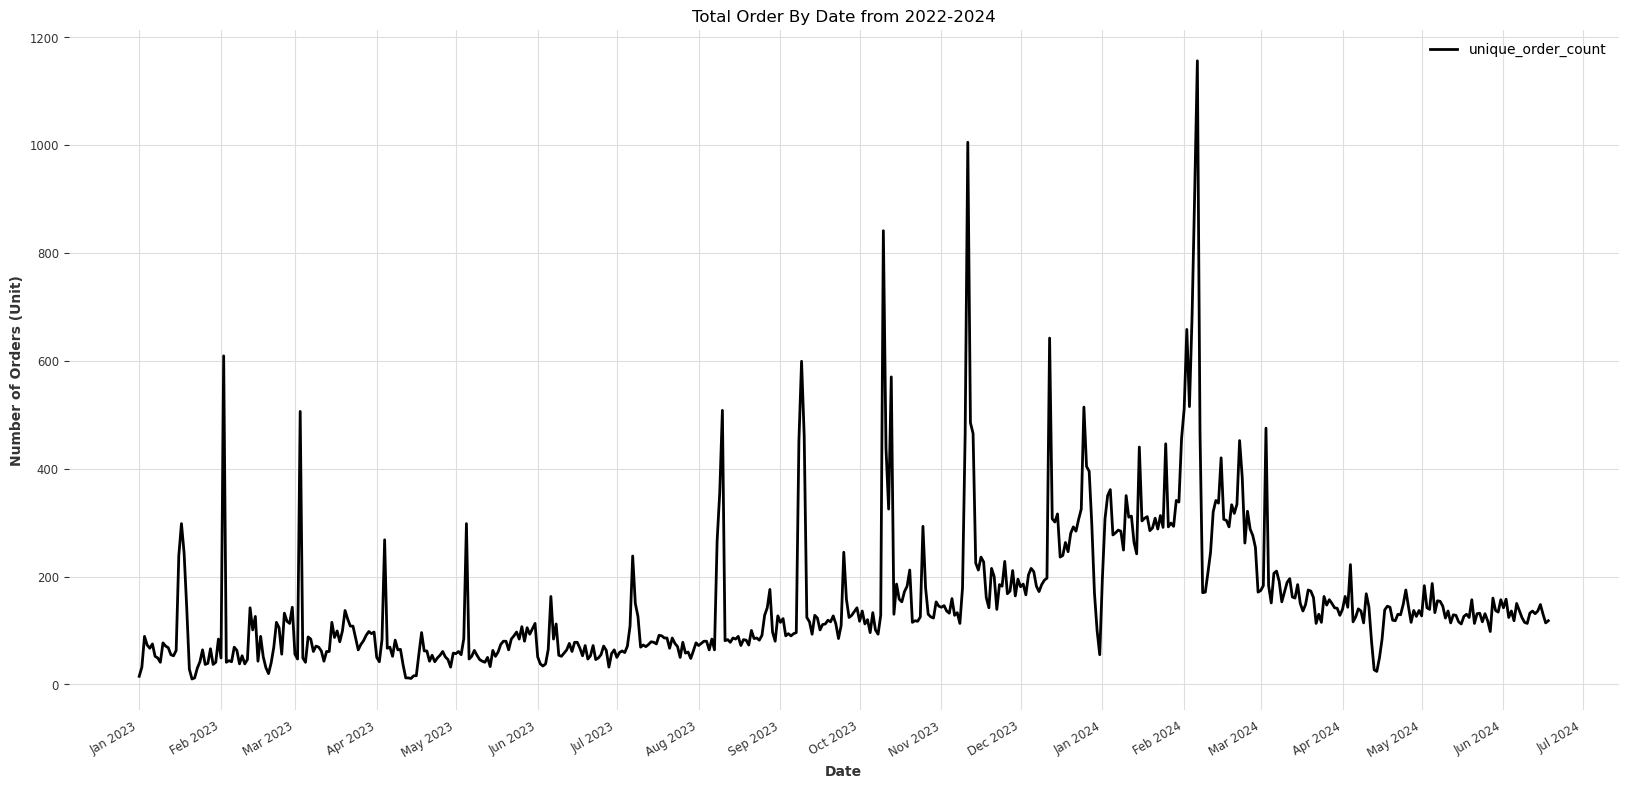

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10)) 
series.plot()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 

plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [64]:
# training, validation =series.split_before(0.9)
# training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month
training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 2 month

validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())

component           unique_order_count
order_completed_at                    
2024-04-26                       144.0
2024-04-27                       115.0
2024-04-28                       137.0
2024-04-29                       126.0
2024-04-30                       137.0
component           unique_order_count
order_completed_at                    
2024-05-01                       127.0
2024-05-02                       183.0
2024-05-03                       142.0
2024-05-04                       139.0
2024-05-05                       187.0


In [65]:
print(validation_df.shape)

(49, 1)


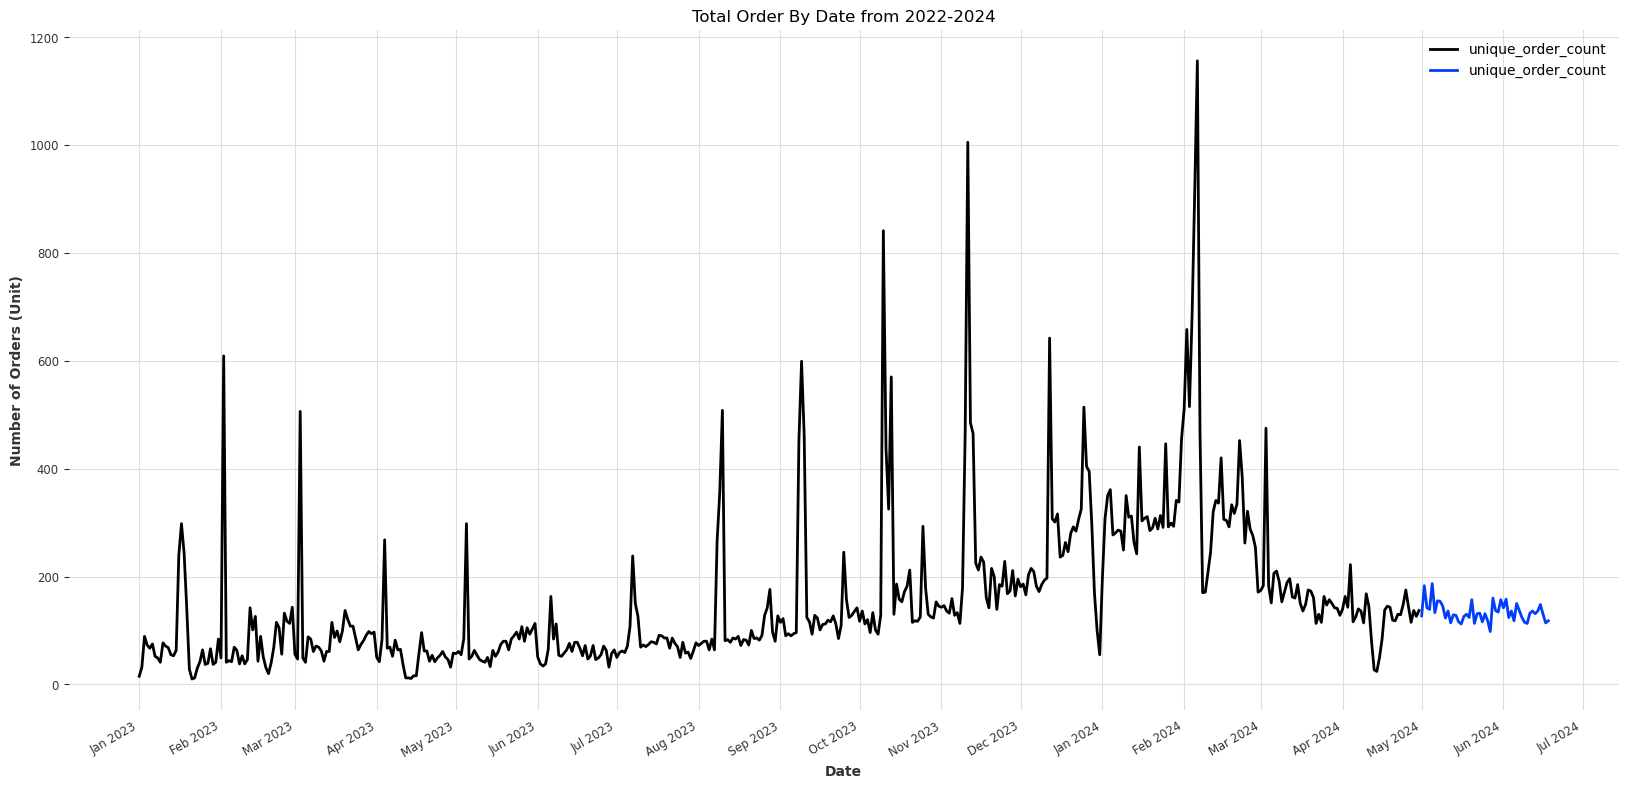

In [66]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [67]:
# from darts.models import Prophet
# from darts.metrics import mape, mae, mse, mase
# from math import sqrt
# from darts.utils.utils import ModelMode, SeasonalityMode

# parameters = {
#     "trend":[ModelMode.ADDITIVE, ModelMode.ADDITIVE],
#     "seasonal": [SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE],
#     'seasonal_periods': [4, 7, 12, 24, 30],
#     "random_state": [42]
# }

# best_parameter = Prophet.gridsearch(
#     parameters=parameters,
#     series = series, #note (training + validation) X only training set!!!
#     start=pd.Timestamp("2024-05-01"),
#     forecast_horizon=7,
#     stride=1,          
#     last_points_only=False,  
#     metric=mape,
#     verbose=-1
# )

In [68]:
from darts.models import Prophet
from darts.metrics import mape, mae, mse, mase
from math import sqrt

model = Prophet(country_holidays="TH")
model.fit(training)

16:59:45 - cmdstanpy - INFO - Chain [1] start processing
16:59:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=TH, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [69]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mape,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)

16:59:49 - cmdstanpy - INFO - Chain [1] start processing
16:59:49 - cmdstanpy - INFO - Chain [1] done processing
16:59:49 - cmdstanpy - INFO - Chain [1] start processing
16:59:49 - cmdstanpy - INFO - Chain [1] done processing
16:59:50 - cmdstanpy - INFO - Chain [1] start processing
16:59:50 - cmdstanpy - INFO - Chain [1] done processing
16:59:50 - cmdstanpy - INFO - Chain [1] start processing
16:59:50 - cmdstanpy - INFO - Chain [1] done processing
16:59:50 - cmdstanpy - INFO - Chain [1] start processing
16:59:50 - cmdstanpy - INFO - Chain [1] done processing
16:59:50 - cmdstanpy - INFO - Chain [1] start processing
16:59:50 - cmdstanpy - INFO - Chain [1] done processing
16:59:51 - cmdstanpy - INFO - Chain [1] start processing
16:59:51 - cmdstanpy - INFO - Chain [1] done processing
16:59:51 - cmdstanpy - INFO - Chain [1] start processing
16:59:51 - cmdstanpy - INFO - Chain [1] done processing
16:59:51 - cmdstanpy - INFO - Chain [1] start processing
16:59:51 - cmdstanpy - INFO - Chain [1]

In [70]:
print(f'backtest_errors MAPE: {backtest_errors}')

backtest_errors MAPE: 20.89990106701642


In [71]:
# result from training , validation only
prediction = model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 15.2148
score ACC: 84.7852
score MSE: 641.584
score RMSE: 25.3295
score MAE: 20.3853


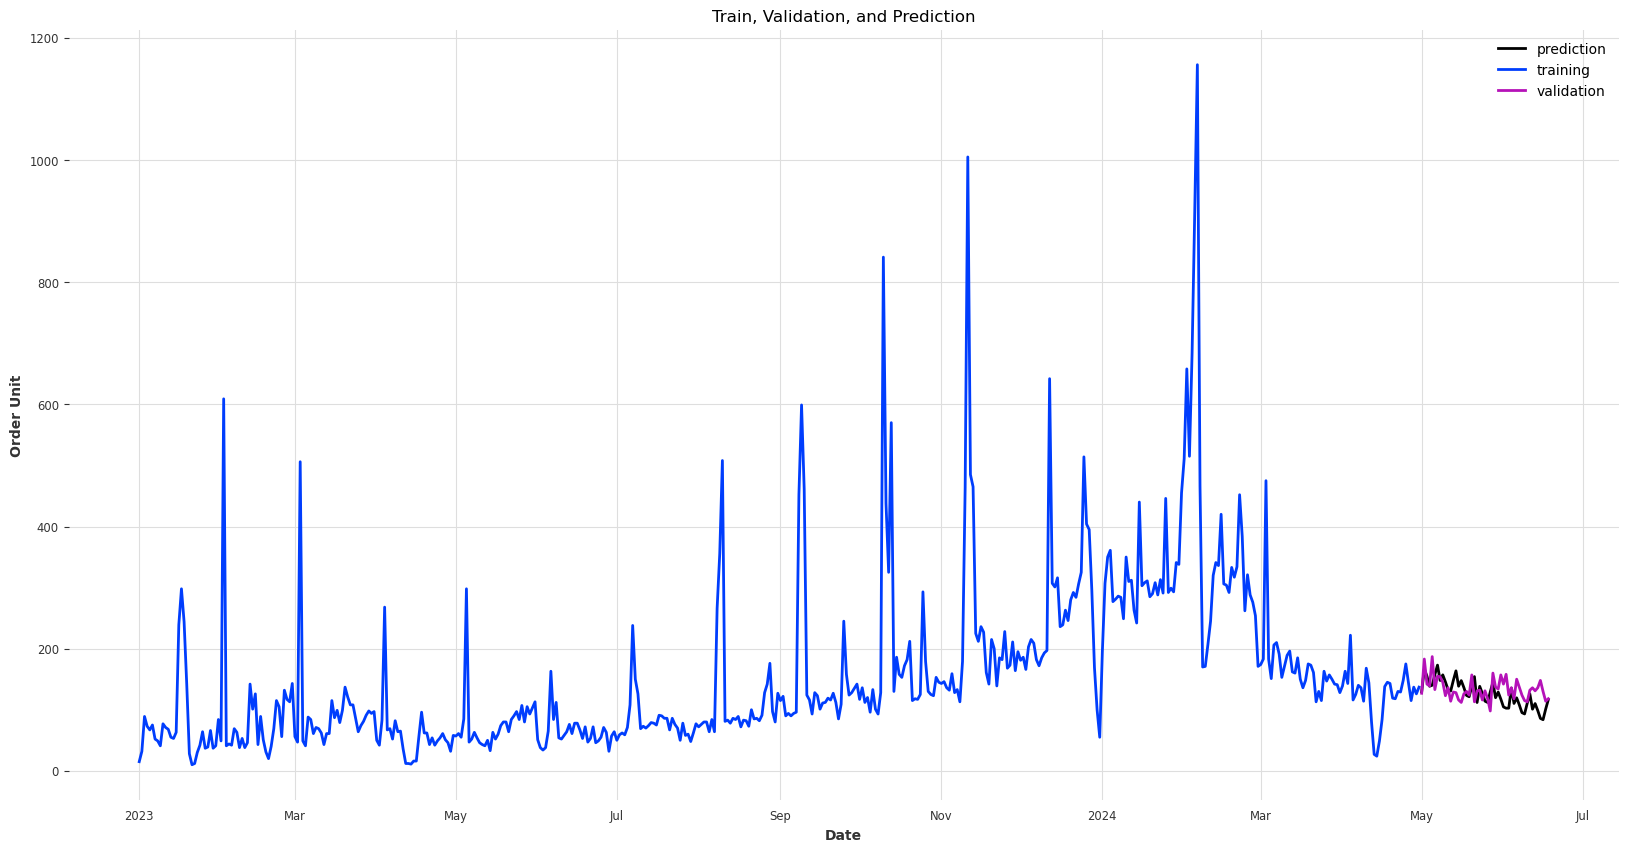

In [73]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [74]:
# predict future
model.fit(series)

17:00:09 - cmdstanpy - INFO - Chain [1] start processing
17:00:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities=None, country_holidays=TH, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [75]:
#check date
series.pd_dataframe().tail(14)

component,unique_order_count
order_completed_at,
2024-06-05,118.0
2024-06-06,150.0
2024-06-07,137.0
2024-06-08,124.0
2024-06-09,115.0
2024-06-10,113.0
2024-06-11,132.0
2024-06-12,136.0
2024-06-13,131.0


In [78]:
forecast = model.predict(7)
# forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
forecast.tail(7)

forecast.to_csv('../forecast/19-25-06-67_prophet.csv', index=False)

In [77]:
model.save("../model/Prophet_19Jun67_1month.pkl")